# A/B тестирование изменений рекомендательинной системы интернет-магазина

Интернет-магазин проводит тестирование изменений, связанных с внедрением улучшенной рекомендательной системы. Основная задача проекта - удостовериться в корректности проведения теста и провести оценку результатов A/B-теста. Однако в первую очередь необходимо убедиться в соотвествии представленных данных техническому заданию: удостовериться, что нет пересечений с конкурирующим тестом и нет пользователей, участвующих в двух группах теста одновременно; проверить равномерность распределения пользователей по тестовым группам и правильность их формирования.

План работы:
1) Первичная проверка и предобработка данных (пробразование типов данных, проверка пропусков и дубликатов);

2) Оценка корректности проведения теста:

    - проверка периода набора пользователей в тест; 
    - проверка пересечений с конкурирующим тестом; 
    - проверка соотвествия региона регистрации пользователей целевому региону; 
    - проверка динамики набора пользователей в группы теста;
    
3) Изучение данных о пользовательской активности;

4) Проведение исследовательского анализа данных;

5) Оценка результатов A/B-тестирования;

6) Вывод и рекомендации.

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
import math as mth
import plotly.express as px

## Загрузка данных

In [2]:
project_events = pd.read_csv('ab_project_marketing_events.csv')
users = pd.read_csv('final_ab_new_users.csv')
participants = pd.read_csv('final_ab_participants.csv')
events = pd.read_csv('final_ab_events.csv')

In [3]:
display(project_events.sort_values(by='start_dt').reset_index(drop=True))
display(users.head())
display(events.head())
display(participants.head())

name                   regions    start_dt  \
0             Chinese New Year Promo                      APAC  2020-01-25   
1       St. Valentine's Day Giveaway  EU, CIS, APAC, N.America  2020-02-14   
2    International Women's Day Promo             EU, CIS, APAC  2020-03-08   
3             St. Patric's Day Promo             EU, N.America  2020-03-17   
4                       Easter Promo  EU, CIS, APAC, N.America  2020-04-12   
5   Labor day (May 1st) Ads Campaign             EU, CIS, APAC  2020-05-01   
6    Victory Day CIS (May 9th) Event                       CIS  2020-05-09   
7      Dragon Boat Festival Giveaway                      APAC  2020-06-25   
8                  4th of July Promo                 N.America  2020-07-04   
9              Chinese Moon Festival                      APAC  2020-10-01   
10           Single's Day Gift Promo                      APAC  2020-11-11   
11         Black Friday Ads Campaign  EU, CIS, APAC, N.America  2020-11-26   
12          Christmas&New Year Promo             EU, N.America  2020-12-25   
13         CIS New Year Gift Lottery                       CIS  2020-12-30   

     finish_dt  
0   2020-02-07  
1   2020-02-16  
2   2020-03-10  
3   2020-03-19  
4   2020-04-19  
5   2020-05-03  
6   2020-05-11  
7   2020-07-01  
8   2020-07-11  
9   2020-10-07  
10  2020-11-12  
11  2020-12-01  
12  2021-01-03  
13  2021-01-07

user_id  first_date     region   device
0  D72A72121175D8BE  2020-12-07         EU       PC
1  F1C668619DFE6E65  2020-12-07  N.America  Android
2  2E1BF1D4C37EA01F  2020-12-07         EU       PC
3  50734A22C0C63768  2020-12-07         EU   iPhone
4  E1BDDCE0DAFA2679  2020-12-07  N.America   iPhone

user_id             event_dt event_name  details
0  E1BDDCE0DAFA2679  2020-12-07 20:22:03   purchase    99.99
1  7B6452F081F49504  2020-12-07 09:22:53   purchase     9.99
2  9CD9F34546DF254C  2020-12-07 12:59:29   purchase     4.99
3  96F27A054B191457  2020-12-07 04:02:40   purchase     4.99
4  1FD7660FDF94CA1F  2020-12-07 10:15:09   purchase     4.99

user_id group                  ab_test
0  D1ABA3E2887B6A73     A  recommender_system_test
1  A7A3664BD6242119     A  recommender_system_test
2  DABC14FDDFADD29E     A  recommender_system_test
3  04988C5DF189632E     A  recommender_system_test
4  482F14783456D21B     B  recommender_system_test

## Предобработка данных

### Изменение типов данных

In [4]:
display(project_events.info())
display(users.info())
display(events.info())
display(participants.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     61733 non-null  object
 1   first_date  61733 non-null  object
 2   region      61733 non-null  object
 3   device      61733 non-null  object
dtypes: object(4)
memory usage: 1.9+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     440317 non-null  object 
 1   event_dt    440317 non-null  object 
 2   event_name  440317 non-null  object 
 3   details     62740 non-null   float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB


None

Во всех таблицах, кроме participants, содержатся даты, однако представлены они как объекты. Заменим типы данных на дату.

In [5]:
project_events['start_dt'] = project_events['start_dt'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))
project_events['finish_dt'] = project_events['finish_dt'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))
users['first_date'] = users['first_date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))
events['event_dt'] = events['event_dt'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))

### Обработка пропусков

Пропуски замечены только в столбце details таблицы events. Проверим их природу.

In [6]:
events.loc[events['details'].notna(), 'event_name'].unique()

array(['purchase'], dtype=object)

In [7]:
events.loc[events['details'].isna(), 'event_name'].unique()

array(['product_cart', 'product_page', 'login'], dtype=object)

Выяснили, что заполнен столбец details только для строк, содержащих информацию о покупках (purchase). В этом случае в столбце details находится стоимость покупки в долларах. По остальным событиям в столбце details пропуски, удалять их нельзя, так как это приведет к потере всех событий клиентов, кроме покупок. 

### Обработка дубликатов

Проверим данные на дубликаты. Таблицу project_events не проверяем - в ней находятся 14 строк с описанием уникальных событий.

In [8]:
print(users.duplicated().sum())
print(events.duplicated().sum())
print(participants.duplicated().sum())

0
0
0


Явных дубликатах в остальных таблицах не обнаружено. Проверим, не повторяются ли user_id.

In [9]:
# проверка уникальности зарегистирировавшихся пользователей из таблицы users

users['user_id'].duplicated().sum()

0

In [10]:
# проверка уникальности пользователей из таблицы events

print(f"{events['user_id'].duplicated().sum()} дублированных user_id")
events.loc[events['user_id'].duplicated(keep=False)].sort_values(by='user_id').head(15).reset_index(drop=True)

381614 дублированных user_id


user_id            event_dt    event_name  details
0   0001710F4DDB1D1B 2020-12-15 17:34:25  product_cart      NaN
1   0001710F4DDB1D1B 2020-12-14 20:20:41  product_page      NaN
2   0001710F4DDB1D1B 2020-12-15 17:34:22         login      NaN
3   0001710F4DDB1D1B 2020-12-14 20:20:42  product_cart      NaN
4   0001710F4DDB1D1B 2020-12-14 20:20:40         login      NaN
5   0001710F4DDB1D1B 2020-12-15 17:34:23  product_page      NaN
6   000199F1887AE5E6 2020-12-20 06:36:36  product_page      NaN
7   000199F1887AE5E6 2020-12-21 02:11:23         login      NaN
8   000199F1887AE5E6 2020-12-20 06:36:35  product_cart      NaN
9   000199F1887AE5E6 2020-12-20 06:36:35      purchase     4.99
10  000199F1887AE5E6 2020-12-15 07:22:56  product_cart      NaN
11  000199F1887AE5E6 2020-12-14 09:56:11  product_cart      NaN
12  000199F1887AE5E6 2020-12-21 02:11:23      purchase    99.99
13  000199F1887AE5E6 2020-12-14 09:56:09         login      NaN
14  000199F1887AE5E6 2020-12-15 07:22:56         login      NaN

В таблице с событиями (действиями) пользователей более 381 тысячи повторов user_id из 440 тысяч строк, что вполне оправдано, учитывая, что пользователи могут совершать различные действия и неограниченное количесвто раз. Выше это продемонстрировано на примере нескольких пользователей.

В таблице participants поле ab_test заполнено 2-мя значениями значениями в зависимости проводимого теста - interface_eu_test и recommender_system_test. Стоит разделить датасет на эти группы, чтобы проверить, нет ли повторов по каждой группе в отдельности.

In [11]:
participants_test_a = participants.query('ab_test=="interface_eu_test"')
participants_test_b = participants.query('ab_test=="recommender_system_test"')
participants_test_a

user_id group            ab_test
6701   D4E530F6595A05A3     A  interface_eu_test
6702   773ECB64E45DEBAB     A  interface_eu_test
6703   6BCB0F33D3BAB8C2     A  interface_eu_test
6704   AABA4219186465C9     A  interface_eu_test
6705   2BA8FA8754D1FE50     B  interface_eu_test
...                 ...   ...                ...
18263  1D302F8688B91781     B  interface_eu_test
18264  3DE51B726983B657     A  interface_eu_test
18265  F501F79D332BE86C     A  interface_eu_test
18266  63FBE257B05F2245     A  interface_eu_test
18267  79F9ABFB029CF724     B  interface_eu_test

[11567 rows x 3 columns]

In [12]:
# проверка уникальности пользователей из таблицы participants_test_a

print(f"{participants_test_a['user_id'].duplicated().sum()} дублированных user_id")
display(participants_test_a.loc[participants_test_a['user_id'].duplicated(keep=False)].sort_values(by='user_id').reset_index(drop=True))

0 дублированных user_id


Empty DataFrame
Columns: [user_id, group, ab_test]
Index: []

In [13]:
# проверка уникальности пользователей из таблицы participants_test_b

print(f"{participants_test_b['user_id'].duplicated().sum()} дублированных user_id")
display(participants_test_b.loc[participants_test_b['user_id'].duplicated(keep=False)].sort_values(by='user_id').reset_index(drop=True))

0 дублированных user_id


Empty DataFrame
Columns: [user_id, group, ab_test]
Index: []

In [14]:
# проверка уникальности пользователей из таблицы

print(f"{participants['user_id'].duplicated().sum()} дублированных user_id по 2-м тестам сразу")
display(participants.loc[participants['user_id'].duplicated(keep=False)].sort_values(by='user_id').reset_index(drop=True))

1602 дублированных user_id по 2-м тестам сразу


user_id group                  ab_test
0     001064FEAAB631A1     B        interface_eu_test
1     001064FEAAB631A1     B  recommender_system_test
2     00341D8401F0F665     A        interface_eu_test
3     00341D8401F0F665     A  recommender_system_test
4     003B6786B4FF5B03     A        interface_eu_test
...                ...   ...                      ...
3199  FFC53FD45DDA5EE8     B  recommender_system_test
3200  FFED90241D04503F     B  recommender_system_test
3201  FFED90241D04503F     B        interface_eu_test
3202  FFF28D02B1EACBE1     B  recommender_system_test
3203  FFF28D02B1EACBE1     A        interface_eu_test

[3204 rows x 3 columns]

В таблице участников тестов также обнаружены повторящиеся user_id, что значит, что некоторые пользователи участвовали сразу в двух тестах (recommender_system_test и interface_eu_test). Причем в двух разных тестах они могли быть отнесены к разным группам (A/B).

## Оценка корректности проведения теста

### Проверка периода набора пользователей в тест

В исследумый тест recommender_system_test должны были попасть пользователи, зарегистрировавшиеся в интернет-магазине с 07.12.2020 по 21.12.2020. Проверим, так ли это. 

In [15]:
# Присоединим к таблице с участниками теста recommender_system_test даты их регистраций

participants = (participants.merge(users[['user_id', 'first_date', 'region']], on='user_id'))
participants.head()

user_id group                  ab_test first_date region
0  D1ABA3E2887B6A73     A  recommender_system_test 2020-12-07     EU
1  A7A3664BD6242119     A  recommender_system_test 2020-12-20     EU
2  DABC14FDDFADD29E     A  recommender_system_test 2020-12-08     EU
3  DABC14FDDFADD29E     A        interface_eu_test 2020-12-08     EU
4  04988C5DF189632E     A  recommender_system_test 2020-12-14     EU

In [16]:
# Проверим, есть ли даты регистрации, не удовлетворяющие нужному диапазону времени 07.12.2020 - 21.12.2020

participants.loc[(participants['ab_test']=='recommender_system_test') &
                ((participants['first_date']<'2020-12-07') | 
                 (participants['first_date']>'2020-12-21'))]

Empty DataFrame
Columns: [user_id, group, ab_test, first_date, region]
Index: []

In [17]:
# Проверим, так же ли обстоят дела с пользователями, отобранными для другого теста - interface_eu_test

participants.loc[(participants['ab_test']=='interface_eu_test') &
                ((participants['first_date']<'2020-12-07') | 
                 (participants['first_date']>'2020-12-21')), 'user_id'].count()

1002

В тест recommender_system_test попали только клиенты, зарегистрировавшиеся в период с 07.12.2020 по 21.12.2020.

А в тесте interface_eu_test есть и пользователи, зарегистрировавшиеся в иной период.

### Проверка пересечений с конкурирующим тестом

Ранее уже было замечено, что в таблице participants содержатся дубликаты по столбцу user_id (1602 user_id - 3204 повтора). Это связано с присутствием в датасете пользователей, которые были отобраны для участия сразу в двух конкурирующих между собой тестированиях.

Отслеживаемыми нами в тесте событиями являются просмотр карточек товаров, просмотр корзины и покупка. И мы не можем с уверенностью сказать, что сценарии теста interface_eu_test не могли повлиять на эти события, скорее всего - они, наоборот, повлияли. А поскольку нас интересует "чистое" влияние сценариев теста recommender_system_test, придется "пожертововать" пользователями, которые были отобраны для участия в обоих тестах, несмотря на то, что они поставляют почти 24% от всех участников тестирования recommender_system_test.

In [18]:
(participants.loc[(participants['user_id'].duplicated(keep=False)) & (participants['ab_test']=='recommender_system_test'), 'user_id'].count()
/participants.loc[participants['ab_test']=='recommender_system_test', 'user_id'].count())

0.23906879570213402

In [19]:
# Выберем пользователей, которые были отобраны для участия в двух тестированиях

two_tests_part = participants.loc[(participants['user_id'].duplicated(keep=False)) & (participants['ab_test']=='recommender_system_test')].sort_values(by='user_id').reset_index(drop=True)
two_tests_part.head(10)

user_id group                  ab_test first_date region
0  001064FEAAB631A1     B  recommender_system_test 2020-12-20     EU
1  00341D8401F0F665     A  recommender_system_test 2020-12-21     EU
2  003B6786B4FF5B03     A  recommender_system_test 2020-12-13     EU
3  0082295A41A867B5     A  recommender_system_test 2020-12-16     EU
4  00E68F103C66C1F7     A  recommender_system_test 2020-12-18     EU
5  00EFA157F7B6E1C4     A  recommender_system_test 2020-12-09     EU
6  010DB4614355A4BB     B  recommender_system_test 2020-12-13     EU
7  0151DAF505060E94     A  recommender_system_test 2020-12-13     EU
8  01B9975CAE144B78     A  recommender_system_test 2020-12-21     EU
9  020A95B66F363AFB     B  recommender_system_test 2020-12-07     EU

In [20]:
# Удалим строки с пользователями, участвовавшими в конкурирующих тестированиях
# Отфильтруем только пользователей из исследуемого тестирования recommender_system_test

participants_recom = participants.loc[(~participants['user_id'].isin(two_tests_part['user_id'])) 
                                     & (participants['ab_test']=='recommender_system_test')]

participants_recom.head()

user_id group                  ab_test first_date region
0  D1ABA3E2887B6A73     A  recommender_system_test 2020-12-07     EU
1  A7A3664BD6242119     A  recommender_system_test 2020-12-20     EU
6  482F14783456D21B     B  recommender_system_test 2020-12-14     EU
7  4FF2998A348C484F     A  recommender_system_test 2020-12-20     EU
8  7473E0943673C09E     A  recommender_system_test 2020-12-16     EU

In [21]:
participants.loc[(participants['user_id'].duplicated(keep=False)) & (participants['ab_test']=='recommender_system_test') & (participants['group']=='A')]

user_id group                  ab_test first_date region
2     DABC14FDDFADD29E     A  recommender_system_test 2020-12-08     EU
4     04988C5DF189632E     A  recommender_system_test 2020-12-14     EU
12    B3A2485649E4A012     A  recommender_system_test 2020-12-09     EU
36    D6E62099519F986C     A  recommender_system_test 2020-12-13     EU
39    0F1FF07B3788976D     A  recommender_system_test 2020-12-07     EU
...                ...   ...                      ...        ...    ...
7908  61AFF952E8EEE554     A  recommender_system_test 2020-12-13     EU
7910  A0BAE4190D41A285     A  recommender_system_test 2020-12-07     EU
7912  28F165B39D160BC5     A  recommender_system_test 2020-12-14     EU
7914  96BDD55846D1F7F6     A  recommender_system_test 2020-12-20     EU
7943  FA86D8DFAD3ADADE     A  recommender_system_test 2020-12-14     EU

[921 rows x 5 columns]

Стоит также проверить, нет ли среди оставшихся пользователей тех, кто попал одновременно в две воронки.

In [22]:
participants_recom.loc[participants_recom['user_id'].duplicated(keep=False)]

Empty DataFrame
Columns: [user_id, group, ab_test, first_date, region]
Index: []

Таких пользователей не обнаружено.

### Проверка региона регистрации пользователей

Ожидаемое количество участников теста: 15% новых пользователей из региона EU.

In [23]:
# Смотрим, из каких регионов участники теста

participants_recom['region'].value_counts()

EU           4749
N.America     223
APAC           72
CIS            55
Name: region, dtype: int64

Целевой регион - Европейский союз (EU), удалим пользователей из других регионов: они не должны попасть в анализ.

In [24]:
participants_recom = participants_recom.query('region=="EU"').reset_index(drop=True)
participants_recom['region'].value_counts()

EU    4749
Name: region, dtype: int64

Кроме того, по ожиданиям в тест должны были попасть 15% от числа новых регистраций. Проверим, так ли это.

In [25]:
print('{0:.1f}%'.format(participants_recom['region'].count() / users.query('region=="EU" & first_date>"2020-12-06" & first_date<"2020-12-22"')['user_id'].count()*100))

11.2%


К сожалению, после отсеивания не удовлетворяющих техническому заданию пользователей количество участников теста меньше ожидаемого на 3,8%.

Таким образом, в датасете participants_recom собраны пользователи-участники теста recommender_system_test, зарегистировавшиеся в период с 07.12.2020 по 21.12.2020, из ЕС.

### Проверка динамики набора пользователей в группы теста

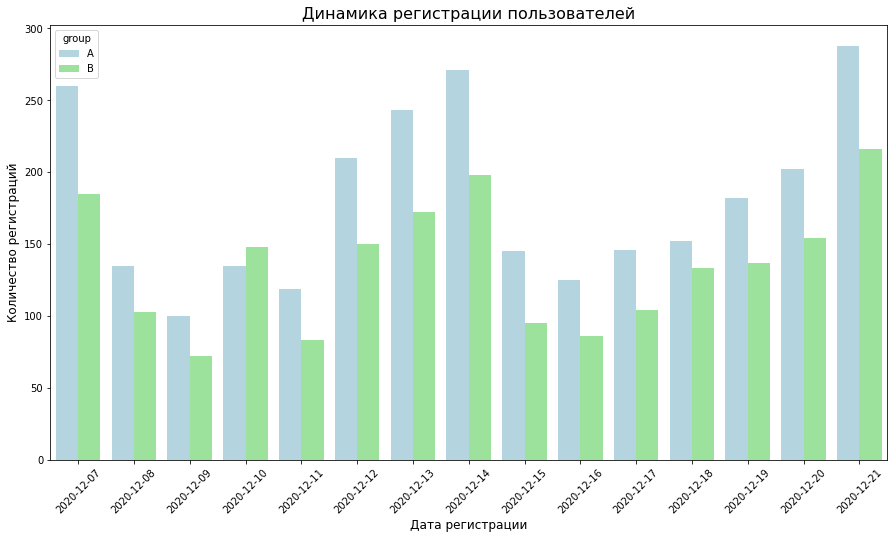

In [26]:
plt.figure(figsize=(15,8))

sns.countplot(data=participants_recom, 
              x=participants_recom['first_date'].dt.date.sort_values(),
              hue=participants_recom['group'],
              palette=['lightblue', 'lightgreen'])
plt.title('Динамика регистрации пользователей', fontsize=16)
plt.xlabel('Дата регистрации', fontsize=12)
plt.ylabel('Количество регистраций', fontsize=12)
plt.xticks(rotation=45)

plt.show()

На графике можно заметить, что группы теста формировались довольно равномерно, пользователей, проходящих по новой платежной воронке, стабильно несколько меньше, чем по действующей, что логично, ведь компания точно знает, с каким результатом работает первая воронка. Количество включенных в группу B пользователей превышает регистрации в группу A только 10.12.2020 - эта аномалия может впоследствии негативно повлиять на общую оценку теста.

Кроме того, привлекает внимание цикличность количества новых регистраций в течение недели: на анализируемом отрезке данных наблюдается увеличения количества новых пользователей к понедельникам (07.12, 14.12, 21.12), когда достигается недельный экстремум, после чего количество регистраций идет на спад, а затем снова прирастает к следующему понедельнику.

## Изучение данных о пользовательской активности

### Даты совершения событий участниками теста

Проверим, совпадают ли даты совершения событий участниками теста с датами проведения теста, согласно техническому заданию (07.12.2020 - 04.01.2021).

In [27]:
events.loc[events['user_id'].isin(participants_recom['user_id']), 'event_dt'].agg(['min', 'max'])

min   2020-12-07 00:16:00
max   2020-12-30 06:42:52
Name: event_dt, dtype: datetime64[ns]

Действия клиентов отобраны верно - минимальная дата события совпадает с датой начала тестирования, максимальная - меньше даты окончания.

### Активность пользователей

Проверим, есть ли среди отобранных пользователей те, что не совершили ни одного действия после регистрации, и сколько их, если такие пользователи есть.

In [28]:
participants_events = participants_recom.merge(events[['user_id', 'event_name', 'event_dt']], on='user_id', how='left')
participants_events['event_dt']=participants_events['event_dt'].dt.date
participants_events_na = participants_events.loc[participants_events['event_name'].isna(), 'user_id']
participants_events_na.count()

2155

In [29]:
participants_recom.loc[participants_recom['user_id'].isin(participants_events_na), 'group'].value_counts(ascending=True)

A     774
B    1381
Name: group, dtype: int64

Да, зарегистрировавшиеся, но не авторизовавшиеся (и т.д.) пользователи есть - 2311 человек, причем большая их часть относится к группе B теста, что парадоксально, ведь в действующую воронку изначально распределялось больше пользователей, чем в тестируемую. Вероятно, это означает, что тестируемая воронка работает хуже действующей. Неактивных пользователей нельзя удалять, так как, удалив их, мы искусственно завысим качество работы новой воронки.

Далее посмотрим, какова конверсия в этапы воронки по остальным пользователям.

In [30]:
# Посчитаем уникальные действия пользователей и добавим их в список

unique_events_count_A=[]
unique_events_count_B=[]
for event in participants_events['event_name'].unique():
    unique_events_count_A.append(len(participants_events.loc[(participants_events['event_name']==event)
                                                             & (participants_events['group']=='A'), 'user_id'].unique())) 
    unique_events_count_B.append(len(participants_events.loc[(participants_events['event_name']==event)
                                                             & (participants_events['group']=='B'), 'user_id'].unique()))    
print(unique_events_count_A)
print(unique_events_count_B)

[613, 589, 1265, 1939, 0]
[191, 184, 367, 655, 0]


In [31]:
unique_events = pd.Series(participants_events['event_name'].unique(), name='event_name').to_frame().join([pd.Series(unique_events_count_A, name='unique_events_count_A'), pd.Series(unique_events_count_B, name='unique_events_count_B')])
unique_events = unique_events[:-1]
unique_events

event_name  unique_events_count_A  unique_events_count_B
0      purchase                    613                    191
1  product_cart                    589                    184
2  product_page                   1265                    367
3         login                   1939                    655

Проходимость воронок двумя группами похожа на всех этапах, кроме первого - просмотр карточек товаров (product_page). Количество дошедших до этого этапа пользователей воронки A (действующей) составляет примерно 65% от предыдущего шага (авторизация), тогда как аналогичный показатель по воронке B составляет только 56%.

In [32]:
print(unique_events.loc[2, 'unique_events_count_A'] / unique_events.loc[3, 'unique_events_count_A']*100)
print(unique_events.loc[2, 'unique_events_count_B'] / unique_events.loc[3, 'unique_events_count_B']*100)

65.23981433728726
56.030534351145036


### Горизонт анализа

In [33]:
# Рассчитаем лайфтайм совершения событий

participants_events['event_lifetime'] = (participants_events['event_dt']-participants_events['first_date'].dt.date).dt.days
print(participants_events['user_id'].count())
display(participants_events.head())

19681


user_id group                  ab_test first_date region  \
0  D1ABA3E2887B6A73     A  recommender_system_test 2020-12-07     EU   
1  D1ABA3E2887B6A73     A  recommender_system_test 2020-12-07     EU   
2  D1ABA3E2887B6A73     A  recommender_system_test 2020-12-07     EU   
3  D1ABA3E2887B6A73     A  recommender_system_test 2020-12-07     EU   
4  D1ABA3E2887B6A73     A  recommender_system_test 2020-12-07     EU   

     event_name    event_dt  event_lifetime  
0      purchase  2020-12-07             0.0  
1      purchase  2020-12-25            18.0  
2  product_cart  2020-12-07             0.0  
3  product_cart  2020-12-25            18.0  
4  product_page  2020-12-07             0.0

In [34]:
# Отсеем события, совершенные более, чем через 14 дней со дня регистрации

participants_events = participants_events.query('event_lifetime<14').reset_index(drop=True)
participants_events['user_id'].count()

16918

Отсеелось более 2,5 тысяч действий пользователей.

Проверим также, успевали ли пользователи совершать события на протяжение 14 дней до окончания теста. Теоритически это так, ведь в анализ попали только пользователи зарегистрировавшиеся максимум 21.12.2020, что за 2 недели до остановки теста.

In [35]:
participants_events.query('first_date=="2020-12-21"')['event_lifetime'].max()

8.0

Максимальная дата совершения события пользователем среди зарегистрировавшихся 21.12.2020 - на 9-й день после регистрации, то есть 30.12.2020.

В следующем шаге оценим, когда пользователи совершают свои первые события каждого вида.

In [36]:
# Выберем минимальные (первые) даты совершения каждым пользователем действия

participants_events_pivot = participants_events.pivot_table(index='user_id', 
                                                            columns=['event_name', 'group'], 
                                                            values='event_lifetime',
                                                            aggfunc='min')
pd.DataFrame(participants_events_pivot)

event_name       login      product_cart     product_page      purchase     
group                A    B            A   B            A    B        A    B
user_id                                                                     
0010A1C096941592   0.0  NaN          NaN NaN          0.0  NaN      0.0  NaN
003DF44D7589BBD4   0.0  NaN          0.0 NaN          0.0  NaN      NaN  NaN
00505E15A9D81546   0.0  NaN          NaN NaN          NaN  NaN      NaN  NaN
005E096DBD379BCF   NaN  0.0          NaN NaN          NaN  NaN      NaN  0.0
006E3E4E232CE760   0.0  NaN          NaN NaN          0.0  NaN      NaN  NaN
...                ...  ...          ...  ..          ...  ...      ...  ...
FF5A1CD38F5DD996   0.0  NaN          NaN NaN          0.0  NaN      NaN  NaN
FF5B24BCE4387F86   0.0  NaN          NaN NaN          0.0  NaN      0.0  NaN
FF825C1D791989B5   0.0  NaN          0.0 NaN          NaN  NaN      NaN  NaN
FF8CF7057415EB29   NaN  0.0          NaN NaN          NaN  0.0      NaN  NaN
FFAE9489C76F352B   0.0  NaN          NaN NaN          0.0  NaN      NaN  NaN

[2594 rows x 8 columns]

In [37]:
# Посчитаем,какое количество пользователей совершали события на каждый из дней лайфтайма

for i in participants_events_pivot.columns:
    display(participants_events_pivot[i].value_counts())

0.0    1933
1.0       2
4.0       1
2.0       1
5.0       1
3.0       1
Name: (login, A), dtype: int64

0.0    644
1.0      4
2.0      2
6.0      2
8.0      1
3.0      1
Name: (login, B), dtype: int64

0.0    588
2.0      1
Name: (product_cart, A), dtype: int64

0.0    181
2.0      1
6.0      1
1.0      1
Name: (product_cart, B), dtype: int64

0.0    1263
1.0       2
Name: (product_page, A), dtype: int64

0.0    360
1.0      2
2.0      2
6.0      1
8.0      1
3.0      1
Name: (product_page, B), dtype: int64

0.0    611
1.0      2
Name: (purchase, A), dtype: int64

0.0    188
1.0      2
6.0      1
Name: (purchase, B), dtype: int64

Большинство пользователей совершают свои первые события каждого вида в день регистрации. Причем разделение количества первых действий по группам теста показывает, что пользователи, проходящие по тестовой воронки (B) совершали значительно меньше событий, чем пользователи из действующей воронки (A).

### Выводы

Соотвествие выборки требованиями технического задания:
- Даты совершения событий участниками в промежутке от 07.12.2020 по 04.01.2021. Верно: действия клиентов отобраны верно - минимальная дата события совпадает с датой начала тестирования, максимальная - меньше даты окончания;
- Анализируемый тест:recommender_system_test. Из датасета были исключены пользователи, участвующие в конкурирующем тесте, и пользователи, участвующие в двух тестах одновременно, так как это могло бы повлиять на результаты исследуемого теста;
- Целевой регион - Европейский союз. Регион большей части отобранных пользователей соотвествовал целевому, однако небольшое количество записей пришлось удалить;
- Ожидаемое количество участников - 15% от новых регистраций в интернет-магазине (в регионе EU).  Данное требование ТЗ не было выполнено: в тест набрали 11,2% от числа новых регистраций по EU;
- Лайфтайм совершения событий пользоватями не более 14 дней: в данных были замечены строки, содержащие события, совершенные более, чем через 14 дней после регистрации. Такие действия были удалены.

Таким образом, не соблюдено только одно требование ТЗ - ожидаемое количество участников. Это несоотвествие вполне может повлиять на достоверность выводов о тесте.

## EDA

### Распределение количества событий на пользователя в разрезе групп теста

In [38]:
# Напишем функцию, которая будет группировать и агрегировать данные по разным признакам

def group_participants(index_1, index_2, count_values, aggfunc):
    grouped_participants = participants_events.pivot_table(index=[index_1, index_2], values=count_values, aggfunc=aggfunc).reset_index()
    return grouped_participants

In [39]:
# Сгруппируем действия по пользовалям и группам теста и посчитаем их количество на каждого пользователя по группам

grouped_by_user_participants = group_participants('group', 'user_id', 'event_name', 'count')
grouped_by_user_participants.head()

group           user_id  event_name
0     A  0010A1C096941592          12
1     A  003DF44D7589BBD4          15
2     A  00505E15A9D81546           5
3     A  006E3E4E232CE760           6
4     A  00A52DCF85F1BE03           2

In [40]:
# Рассчитаем среднее количество событий по групппам теста

grouped_by_user_participants.groupby('group').agg('mean')

C:\Users\Игорь\AppData\Local\Temp\ipykernel_11236\3619689060.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped_by_user_participants.groupby('group').agg('mean')


event_name
group            
A        6.897370
B        5.410687

Очевидно, пользователи, проходящие по тестовой воронке, совершают меньше событий.

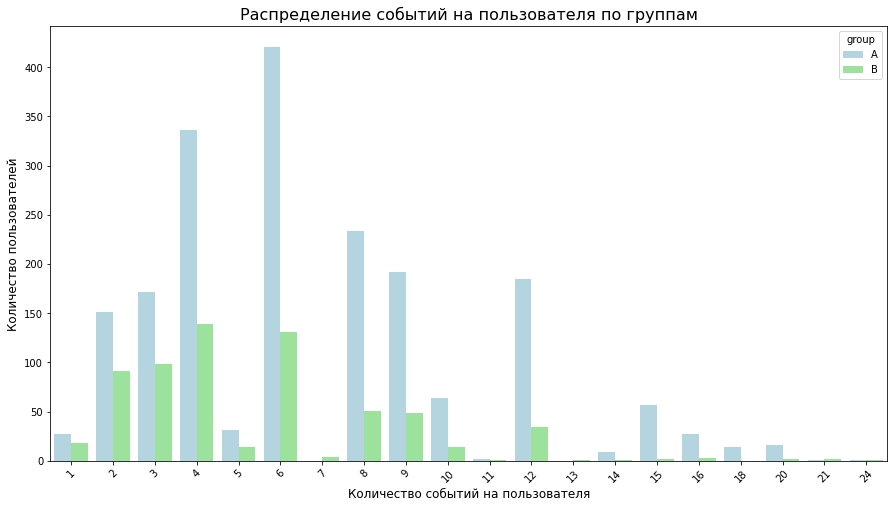

In [41]:
# Построим гистограмму, демонстрирубщую распределение количества событий на пользователя в разрезе групп теста

plt.figure(figsize=(15,8))

sns.countplot(data=grouped_by_user_participants, 
              x=grouped_by_user_participants['event_name'],
              hue=grouped_by_user_participants['group'],
              palette=['lightblue', 'lightgreen'])
plt.title('Распределение событий на пользователя по группам', fontsize=16)
plt.xlabel('Количество событий на пользователя', fontsize=12)
plt.ylabel('Количество пользователей', fontsize=12)
plt.xticks(rotation=45)

plt.show()

По графику выше можно сделать следующие выводы:
- Максимальное (не аномальное по количеству повторений) количество осуществляемых пользователями группы B действий - 12, однако есть и пользователи (но их до 10 человек), что совершили более 20 событий;
- На распределении пользователей группы A выделяется экстремум - 6 событий - именно такое количество действий чаще всего совершали пользователи этой группы. Можно предположить, что это связано с тем, что зачастую пользователи авторизовывались, затем просматривали карточку товара и корзину, но не покупали, а потом еще раз совершали такой же пользовательский путь (3 этапа по  раза);
- Основная часть пользователей обеих групп совершала от 2 до 12 событий;
- Замечены аномальные провалы в количестве пользователей, совершавших события 5, 7 и 11 раз. Провал по, например, количеству пользователей с 5-ю событиями может быть связан с тем, что после прохождения 4-х этапов вплоть до покупки, клиент удовлетворяет свои потребности этим приоретением и больше не видит смысла в ближайшее время пользоваться услугами игтернет-магазина.

### Динамика количества событий в группах теста по лайфтаймам и дням

In [42]:
# Сгруппируем действия по лайфтаймам событий и группам теста и посчитаем их количество на каждый лайфтайм

grouped_by_user_lifetime = group_participants('group', 'event_lifetime', 'event_name', 'count')
grouped_by_user_lifetime.head()

group  event_lifetime  event_name
0     A             0.0        4395
1     A             1.0        2169
2     A             2.0        1487
3     A             3.0        1042
4     A             4.0         834

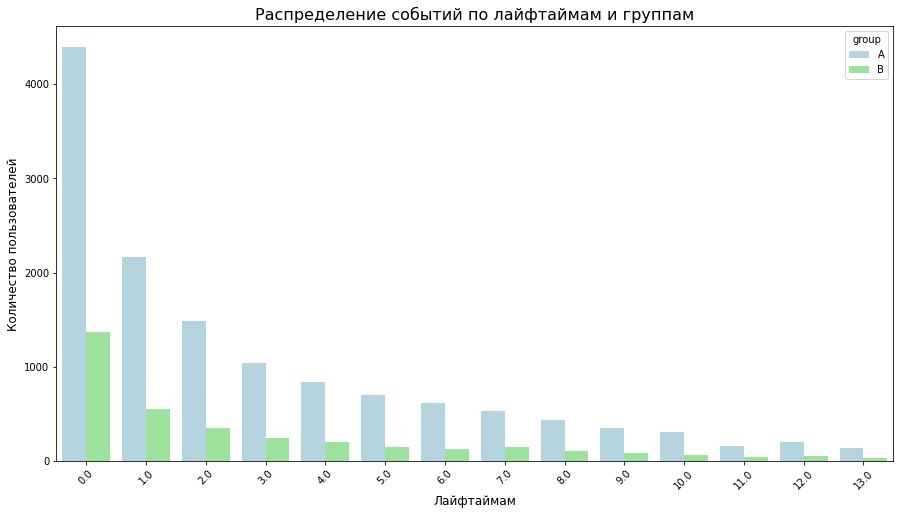

In [43]:
plt.figure(figsize=(15,8))

sns.barplot(data=grouped_by_user_lifetime, 
            x=grouped_by_user_lifetime['event_lifetime'],
            y=grouped_by_user_lifetime['event_name'],
            hue=grouped_by_user_lifetime['group'],
            palette=['lightblue', 'lightgreen'])
plt.title('Распределение событий по лайфтаймам и группам', fontsize=16)
plt.xlabel('Лайфтаймам', fontsize=12)
plt.ylabel('Количество пользователей', fontsize=12)
plt.xticks(rotation=45)

plt.show()

Наблюдения:
- Количество совершенных событий по каждому лайфтайму по группе A примерно в 3 раза выше чем у участников группы B;
- По обеим группам число событий снижается к концу анализируемой продолжительности "жизни" пользователей.

In [44]:
# Сгруппируем действия по лайфтаймам событий и группам теста и посчитаем их количество на каждый лайфтайм

grouped_by_user_dt = group_participants('group', 'event_dt', 'event_name', 'count')
grouped_by_user_dt.head()

group    event_dt  event_name
0     A  2020-12-07         221
1     A  2020-12-08         239
2     A  2020-12-09         282
3     A  2020-12-10         246
4     A  2020-12-11         264

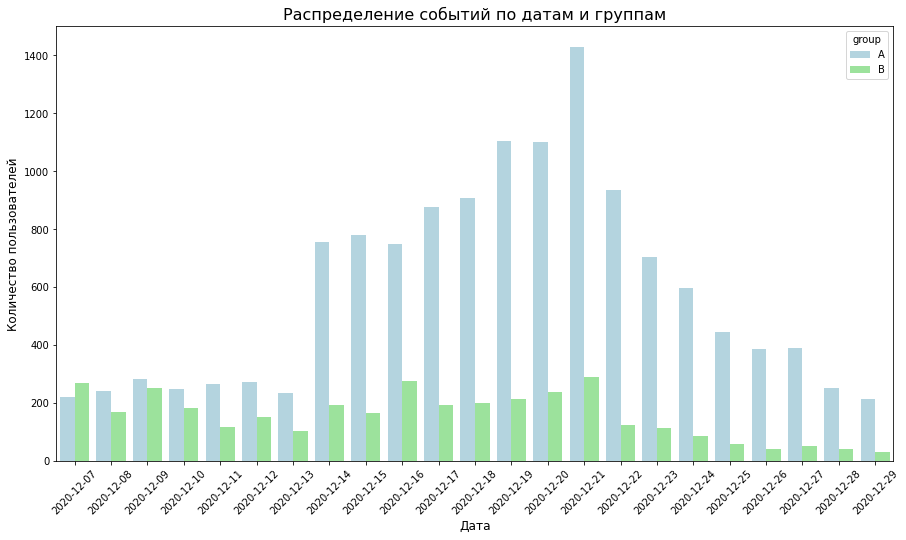

In [45]:
plt.figure(figsize=(15,8))

sns.barplot(data=grouped_by_user_dt, 
            x=grouped_by_user_dt['event_dt'],
            y=grouped_by_user_dt['event_name'],
            hue=grouped_by_user_dt['group'],
            palette=['lightblue', 'lightgreen'])
plt.title('Распределение событий по датам и группам', fontsize=16)
plt.xlabel('Дата', fontsize=12)
plt.ylabel('Количество пользователей', fontsize=12)
plt.xticks(rotation=45)

plt.show()

В первый день регистрации число событий тестируемой группы пользователей превысило аналогичый показатель контрольной группы. Далее на протяжение всего теста такого больше не повторялось. 

Стоит отметить, что количество дейтсвий пользователей группы B довольно стабильно, но с 22-го декабря существенно снизилось и изменялось незначительно. Тогда как количество событий пользователей группы A резко возросло 14.12.2020 и достигло своего пика 21.12.2020 в более чем 1400 событий на день; однако потом начало снижаться и к концу тестирования вернулось к изначальному уровню.

### Совпадение времени проведения теста с другими активностями

In [46]:
# Создадим автоматическую проверку, выдающую список событий (дат событий), пересекающихся с тестом

def overlap_of_dates_check(test_start_date, test_finish_date, event_start_date, event_finish_date):
    
    event_start_date = pd.to_datetime(event_start_date)
    event_finish_date = pd.to_datetime(event_finish_date)

    test_start_date = pd.to_datetime(test_start_date)
    test_finish_date = pd.to_datetime(test_finish_date)
    
    delta = (test_finish_date - test_start_date)

    test_dates = pd.date_range(test_start_date, periods=delta.days+1)
    
    for i in test_dates:
        if (i >= event_start_date and
            i <= event_finish_date):
            print(f'Внимание! Дата проведения теста {i} совпадает с датой иной активности')

In [47]:
overlap_of_dates_check('2020-12-07', '2021-01-04', '2020-12-25', '2021-01-03')

Внимание! Дата проведения теста 2020-12-25 00:00:00 совпадает с датой иной активности
Внимание! Дата проведения теста 2020-12-26 00:00:00 совпадает с датой иной активности
Внимание! Дата проведения теста 2020-12-27 00:00:00 совпадает с датой иной активности
Внимание! Дата проведения теста 2020-12-28 00:00:00 совпадает с датой иной активности
Внимание! Дата проведения теста 2020-12-29 00:00:00 совпадает с датой иной активности
Внимание! Дата проведения теста 2020-12-30 00:00:00 совпадает с датой иной активности
Внимание! Дата проведения теста 2020-12-31 00:00:00 совпадает с датой иной активности
Внимание! Дата проведения теста 2021-01-01 00:00:00 совпадает с датой иной активности
Внимание! Дата проведения теста 2021-01-02 00:00:00 совпадает с датой иной активности
Внимание! Дата проведения теста 2021-01-03 00:00:00 совпадает с датой иной активности


Найдены пересечения дат событий c 25.12.2020 по 03.01.2023.

In [48]:
# Продублируем таблицу с другими активностями (кроме тестов), отфильтровав устаревшие для нашего анализа

project_events.sort_values(by='start_dt').reset_index(drop=True).query('finish_dt>"2020-12-01"')

name        regions   start_dt  finish_dt
12   Christmas&New Year Promo  EU, N.America 2020-12-25 2021-01-03
13  CIS New Year Gift Lottery            CIS 2020-12-30 2021-01-07

Действительно в декабре были запущены 2 активности, они начались после окончания регистрации пользователей для теста, но еще могли повлиять на некоторые действия пользователей. Что касается 2-ой активности - CIS New Year Gift Lottery, она была запущена после завершения теста. 

Но влияние первой активности (Christmas&New Year Promo) можно заметить визуально на графике, демонстрирующем распределение событий по датам и группам, выше (пункт 5.2). Влияние активности на результаты группы A очевидны: с 21.12.2020 число событий по группе стало существенно уменьшаться, однако 26.12.2020 - остановилось на дня, а далее изменялось уже не так значительно. Такое распределение можно объяснить влиянием запустившейся активности.

Воздействие же активности на тестовую группу не так заметно, но по тенденции изменения распределения числа событий можно предположить, что оно могло снижаться стремительнее, если бы не введение активности.

Таким образом, можно сделать вывод, что пересечение теста с Christmas&New Year Promo могло и скорее всего повлияло на эффект от теста, но поскольку активность повлияла на обе группы пользователей теста, избавляться от событий после 24.12.2020 не будем, в том числе чтобы не терять еще больше данных.

In [49]:
participants_events.query('event_dt>=@pd.to_datetime("2020-12-25").date()').count()

user_id           1905
group             1905
ab_test           1905
first_date        1905
region            1905
event_name        1905
event_dt          1905
event_lifetime    1905
dtype: int64

In [50]:
participants_events['event_dt'].max()

datetime.date(2020, 12, 29)

### Продуктовая воронка

Для построения воронок для начала изучим изменения конверсии по тестам. Ранее (пункт 4.2) мы уже создавали таблицу, содержащую количество уникальных пользователей на каждом этапе воронок в разбивке по тестам. Воспользуемся ей.

In [51]:
# Выведем таблицу, полученную в пункте 4.2

unique_events

event_name  unique_events_count_A  unique_events_count_B
0      purchase                    613                    191
1  product_cart                    589                    184
2  product_page                   1265                    367
3         login                   1939                    655

In [52]:
# Посчитаем в каждый этап относительно первого этапа - регистрации - b относительно предыдущего этапа

for i in unique_events.index:
    unique_events.loc[i, 'conversion_A'] = unique_events.loc[i, 'unique_events_count_A']/participants_events['group'].value_counts()[0] 
    unique_events.loc[i, 'conversion_B'] = unique_events.loc[i, 'unique_events_count_B']/participants_events['group'].value_counts()[1]

    
for i in unique_events.index:
    if i < 3:
        unique_events.loc[i, 'step_conversion_A'] = unique_events.loc[i, 'unique_events_count_A']/unique_events.loc[i+1, 'unique_events_count_A']
        unique_events.loc[i, 'step_conversion_B'] = unique_events.loc[i, 'unique_events_count_B']/unique_events.loc[i+1, 'unique_events_count_B']
        
unique_events

event_name  unique_events_count_A  unique_events_count_B  conversion_A  \
0      purchase                    613                    191      0.045835   
1  product_cart                    589                    184      0.044041   
2  product_page                   1265                    367      0.094587   
3         login                   1939                    655      0.144983   

   conversion_B  step_conversion_A  step_conversion_B  
0      0.053894           1.040747           1.038043  
1      0.051919           0.465613           0.501362  
2      0.103555           0.652398           0.560305  
3      0.184819                NaN                NaN

Отметим, что участники группы B лучше проходят этапы воронки при сравнении с изначальным количеством.

Что касается конверсии по шагам, переходов к карточкам товаров у участников группы B меньше на 9 процентных пунктов, чем по группе A. Однако просмотры корзин просматривает 50,1% от просмотревших карточки среди пользователей группы B, тогда как аналогичный показатель по группе A составил 46,6%, что на 3,5 п.п. меньше. Конверсии в оплаты схожи по двум воронкам: 104,1% по группе A и 103,8% по группе B.

Далее визуализируем воронку.

In [53]:
# Создадим список этапов
stages = list(unique_events['event_name'][::-1])

# Создадим таблицы с этапами, количеством уникальных событий и группами
df_A = pd.DataFrame(dict(count=list(unique_events['unique_events_count_A'][::-1]), stage=stages))
df_A['group'] = 'A'

df_B = pd.DataFrame(dict(count=list(unique_events['unique_events_count_B'][::-1]), stage=stages))
df_B['group'] = 'B'

# Объединим таблицы по группам
df = pd.concat([df_A, df_B])

# Рисуем воронку
fig = px.funnel(df, x='count', y='stage', color='group')


fig.show()

### Выводы

Ожидалось, что за 14 дней с момента регистрации в системе пользователи покажут улучшение каждой метрики по тестовой воронке не менее, чем на 5 процентных пунктов конверсии в просмотр карточек товаров, просмотры корзины, покупки.

Однако ожидания не оправдались ни по одному переходу:

- конверсии в просмотр карточек товаров по группе B ниже, чем по группе A на 9 процентных пунктов;
- конверсии в просмотр корзины по группе B только на 3,5 процентных пункта выше, чем по группе A;
- конверсии в оплаты схожи по двум воронкам: 103,8% - по группе B и 104,1% - по группе A.

Это можно объяснить как несоответсвующим плану количеством принимаемых участие в тесте пользователей, так и удалением пользователей, принимавших участие в 2-х конкурирующих тестах одновременно, или, что и требуется доказать или опровергнуть, эффективностью введенных в тестовую воронку изменений. В последнем можно удостовериться через проведение проверки статистической значимости различий метрик (конверсий).

## Оценка результатов A/B-тестирования

### Проверка статистической разницы долей z-критерием

In [54]:
# Назначим критический уровень стат. значимости

alpha = 0.05/3

Поскольку уже было выяснено, что конверсии в покупку по двум воронкам почти не отличаются, имеет смысл проверить только стат. значимость различий между конверсиями в просмотр карточек товаров и просмотр корзины. Тем не менее, стоит дополнительно убедиться в правильности сделанных выводов. 

Для проверки понадобится подготовленная ранее (пункт 5.4) таблица unique_events.

In [55]:
unique_events

event_name  unique_events_count_A  unique_events_count_B  conversion_A  \
0      purchase                    613                    191      0.045835   
1  product_cart                    589                    184      0.044041   
2  product_page                   1265                    367      0.094587   
3         login                   1939                    655      0.144983   

   conversion_B  step_conversion_A  step_conversion_B  
0      0.053894           1.040747           1.038043  
1      0.051919           0.465613           0.501362  
2      0.103555           0.652398           0.560305  
3      0.184819                NaN                NaN

Проверять будет следующие гипотезы:

__Нулевая гипотеза (H0):__ Между конверсиями нет различий

__Альтернативная гипотеза (H1):__ Между конверсиями наблюдаются различия

In [56]:
# Напишем функцию, которая будет подготавливать данные для проверки для расчета z-value, 
# считать p-value и сравнивать с критическим уровнем

def stat_significance_check(i):
    
    # Сумма в знаменателе (число пользователей на предыдущем этапе)
    count_A = unique_events.loc[i+1, 'unique_events_count_A']
    count_B = unique_events.loc[i+1, 'unique_events_count_B']
    
    # Конверсии по группам A и B
    conv_A = unique_events.loc[i, 'step_conversion_A']
    conv_B = unique_events.loc[i, 'step_conversion_B']
    
    
    
    # Совокупная конверсия по всем участникам теста
    conv_combined=((unique_events.loc[i, 'unique_events_count_A'] + unique_events.loc[i, 'unique_events_count_B']) / 
                   (unique_events.loc[i+1, 'unique_events_count_A'] + unique_events.loc[i+1, 'unique_events_count_B']))
    
    # Разница в конверсиях (в процентных пунктах)
    difference = unique_events.loc[i, 'step_conversion_B'] - unique_events.loc[i, 'step_conversion_A']
    
    # Задаем стандартное нормальное распределение со средним 0 и стандартным отклонением 1
    distr = st.norm(0, 1)
    
    # Z-статистика в стандартных отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(abs(conv_combined * (1 - conv_combined) * (1/count_A + 1/count_B)))
    
    # Вычисляем p-value
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    
    # Что проверяем?
    print(f'''Конверсия в {unique_events.loc[i, 'event_name']}''')
    
    # Выводим p-value
    print('p-значение: ', p_value)
    
    # Проверка стат. значимости с помощью сравнения с критическим уровнем
    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между конверсиями есть значимая разница')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать конверсии разными') 

In [57]:
# Выводим результаты проверок

print(stat_significance_check(2))

print(stat_significance_check(1))

print(stat_significance_check(0))

Конверсия в product_page
p-значение:  2.457788807452843e-05
Отвергаем нулевую гипотезу: между конверсиями есть значимая разница
None
Конверсия в product_cart
p-значение:  0.2271990799780692
Не получилось отвергнуть нулевую гипотезу, нет оснований считать конверсии разными
None
Конверсия в purchase
p-значение:  0.8754491654112049
Не получилось отвергнуть нулевую гипотезу, нет оснований считать конверсии разными
None


### Выводы

Только отличия между конверсиями в просмотр карточек товаров были признаны значимыми, в остальных случаях, вероятность того, что отличия получены случайно превышает критический порог значимости, поэтому гипотезы об отсутствии различий между метриками не получилось отвергнуть. 

Важно отметить, что разница в конверсиях в просмотр карточек товаров демонстрирует лучшую работу действующей воронки, а не тестовой.

Таким образом, на основе проверки статистической значимости различий в конверсиях по этапам воронки можно сделать вывод, что ожидаемые от проведения теста результаты не были получены.

## Выводы

Ожидалось, что за 14 дней с момента регистрации в системе пользователи покажут улучшение каждой метрики по тестовой воронке не менее, чем на 5 процентных пунктов конверсии в просмотр карточек товаров, просмотры корзины, покупки.

Однако ожидания не оправдались ни по одному переходу:

- конверсии в просмотр карточек товаров по группе B ниже, чем по группе A на 9 процентных пунктов;
- конверсии в просмотр корзины по группе B только на 3,5 процентных пункта выше, чем по группе A;
- конверсии в оплаты схожи по двум воронкам: 103,8% - по группе B и 104,1% - по группе A.

Кроме того проведенные впоследствии проверки статистической значимости этих отличий показали, что только разница конверсиях по этапам воронки была получена не случайно, но она доказывает качество работы действующей воронки, а не тестовой, как ожидалось.

__Рекомендации__:

Поскольку в процессе обработки данных и проверки корректности и соотвествию их тех. заданию было выяснно, что в тесте принимают участие пользователи, одновременно участвующие в конкурирующих тестированиях, пришлось удалить почти четверть строк с данными о пользователях потенциальных участниках теста recommender_system_test, так как нельзя утверждать, что тест interface_eu_test не мог повлиять на эффект анализируемого тестирования. Это скорее всего и повлекло за собой невыполнение в том числе  количественного требования ТЗ. 

Таким образом, основная рекомендация при проведении последующих тестирований: следить за тем, чтобы к одним и тем же пользователям не применялись сценарии нескольких тестов одновременно.